In [1]:
import pandas as pd 
import numpy as np
import requests
import io
import csv
from path import Path
import psycopg2
from matplotlib import pyplot as plt
#from config import db_password

# Expand cols
pd.set_option('display.max_columns', 80)
pd.options.mode.chained_assignment = None

### CREATE DATASET

In [2]:
# Connction to AWS nba database
connection = psycopg2.connect(
    host = 'nba-db.cpmpsi1pfaz0.us-east-2.rds.amazonaws.com',
    port = 5432,
    user = 'postgres',
    password = 'caf3rac3',
    database='postgres'
    )
cursor=connection.cursor()

In [3]:
#read in data from database for All NBA table
nba_unpivoted_sql = 'SELECT * FROM public.allnba_unpivoted'
All_NBA_Unpivoted_df = pd.read_sql(nba_unpivoted_sql, con=connection).drop(['Lg'],axis=1)
#rename the players column
All_NBA_Unpivoted_df=All_NBA_Unpivoted_df.rename(columns = {'Value':'PlayerName'})
#create column with the start year
All_NBA_Unpivoted_df['Season_Start_Year'] = All_NBA_Unpivoted_df['Season'].apply(lambda row: row[0:4])
All_NBA_Unpivoted_df['Season_Start_Year'] = pd.to_numeric(All_NBA_Unpivoted_df['Season_Start_Year'])
#All_NBA_Unpivoted_df.head(15)

In [4]:
#make dummies for position and team (1st, 2nd, 3rd)
All_NBA_Unpivoted_df = pd.get_dummies(All_NBA_Unpivoted_df,columns=['Position','Tm']).drop(['Season'],axis=1)
#rename the columns (cosmetic)
All_NBA_Unpivoted_df=All_NBA_Unpivoted_df.rename(columns = {'Position_C':'AllNBA_Center'})
All_NBA_Unpivoted_df=All_NBA_Unpivoted_df.rename(columns = {'Position_F':'AllNBA_Forward'})
All_NBA_Unpivoted_df=All_NBA_Unpivoted_df.rename(columns = {'Position_G':'AllNBA_Guard'})
#All_NBA_Unpivoted_df.head(10)

In [5]:
#get list of all of the players that have made an all nba team
AllNBAPlayersList = All_NBA_Unpivoted_df['PlayerName'].unique()
#AllNBAPlayersList

In [6]:
#read in data from database for season stats table
seasons_stats_sql = 'SELECT * FROM public.seasons_stats'
season_stats_df = pd.read_sql(seasons_stats_sql, con=connection)
#divid year into season start and end
season_stats_df=season_stats_df.rename(columns = {'Year':'Year_season_end'})
season_stats_df['Year_season_end'] = pd.to_numeric(season_stats_df['Year_season_end'])
season_stats_df['Year_season_start'] = (season_stats_df['Year_season_end'] - 1)
season_stats_df['Player'] = season_stats_df['Player'].apply(lambda row: row.replace("*",""))



In [7]:
# Make sure that the games played for 2021 is normalized to 82 games
# 72 games in 2021 
# 1998-1999 50 games
# 2011-2011 66 games

filename =  r'Stat_Glossary.xlsx'
stat_glossary = pd.read_excel(filename) 
scaled_stats = stat_glossary[stat_glossary.Scaled_Per_Game != 0].reset_index().drop(['index'], axis=1).Stat

def scale_stats_per_season(season_df, num_games, year):
    for stat in scaled_stats:
        season_df[stat].loc[season_df['Year_season_end']==year] = season_df[stat].loc[season_df['Year_season_end']==year] * 82/num_games
    return season_df


In [8]:
scale_stats_per_season(season_stats_df,50,1999)
scale_stats_per_season(season_stats_df,66,2012)
scale_stats_per_season(season_stats_df,75,2020)

,Year_season_end,Player,Pos,Age,Tm,G,GS,MP,PER,TS_pct,3PAr,FTr,ORB_pct,DRB_pct,TRB_pct,AST_pct,STL_pct,BLK_pct,TOV_pct,USG_pct,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG_pct,3P,3PA,3P_pct,2P,2PA,2P_pct,eFG_pct,FT,FTA,FT_pct,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year_season_start
0,2018,Álex Abrines,SG,24,OKC,75.000000,8.000000,1134.000000,9.0,0.567,0.759,0.158,2.5,8.9,5.6,3.4,1.7,0.6,7.4,12.7,1.300000,1.000000,2.200000,0.094,-1.9,0.4,-1.5,0.100000,115.000000,291.000000,0.395,84.000000,221.000000,0.380,31.000000,70.000000,0.443,0.540,39.000000,46.000000,0.848,26.000000,88.000000,114.000000,28.000000,38.000000,8.000000,25.000000,124.000000,353.000000,2017
1,2018,Quincy Acy,PF,27,BRK,70.000000,8.000000,1359.000000,8.2,0.525,0.800,0.164,3.1,17.1,10.0,6.0,1.2,1.6,13.3,14.4,-0.100000,1.100000,1.000000,0.036,-2.6,0.1,-2.5,-0.200000,130.000000,365.000000,0.356,102.000000,292.000000,0.349,28.000000,73.000000,0.384,0.496,49.000000,60.000000,0.817,40.000000,217.000000,257.000000,57.000000,33.000000,29.000000,60.000000,149.000000,411.000000,2017
2,2018,Steven Adams,C,24,OKC,76.000000,76.000000,2487.000000,20.6,0.630,0.003,0.402,16.6,13.9,15.3,5.5,1.8,2.8,13.3,16.7,6.700000,3.000000,9.700000,0.187,1.7,-0.6,1.1,2.000000,448.000000,712.000000,0.629,0.000000,2.000000,0.000,448.000000,710.000000,0.631,0.629,160.000000,286.000000,0.559,384.000000,301.000000,685.000000,88.000000,92.000000,78.000000,128.000000,215.000000,1056.000000,2017
3,2018,Bam Adebayo,C,20,MIA,69.000000,19.000000,1368.000000,15.7,0.570,0.021,0.526,9.7,21.6,15.6,11.0,1.2,2.5,13.6,15.9,2.300000,1.900000,4.200000,0.148,-1.1,0.7,-0.4,0.600000,174.000000,340.000000,0.512,0.000000,7.000000,0.000,174.000000,333.000000,0.523,0.512,129.000000,179.000000,0.721,118.000000,263.000000,381.000000,101.000000,32.000000,41.000000,66.000000,138.000000,477.000000,2017
4,2018,Arron Afflalo,SG,32,ORL,53.000000,3.000000,682.000000,5.8,0.516,0.432,0.160,0.6,10.1,5.3,6.2,0.3,1.1,10.8,12.5,-0.100000,0.200000,0.100000,0.009,-3.8,-1.5,-5.4,-0.600000,65.000000,162.000000,0.401,27.000000,70.000000,0.386,38.000000,92.000000,0.413,0.485,22.000000,26.000000,0.846,4.000000,62.000000,66.000000,30.000000,4.000000,9.000000,21.000000,56.000000,179.000000,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20945,2020,Trae Young,PG,21,ATL,65.600000,65.600000,2317.866667,23.9,0.595,0.455,0.448,1.6,11.5,6.5,45.6,1.4,0.3,16.2,34.9,5.794667,0.656000,6.450667,0.133,6.2,-2.3,3.9,3.389333,596.960000,1365.573333,0.437,224.133333,621.013333,0.361,372.826667,744.560000,0.501,0.519,525.893333,611.173333,0.860,34.986667,243.813333,278.800000,612.266667,71.066667,8.746667,315.973333,113.706667,1943.946667,2019
20946,2020,Cody Zeller,C,27,CHO,63.413333,42.640000,1466.160000,18.8,0.576,0.157,0.374,12.6,21.2,16.7,11.3,1.5,1.7,11.9,20.8,2.514667,1.421333,3.936000,0.129,0.2,-0.8,-0.6,0.546667,274.426667,523.706667,0.524,19.680000,82.000000,0.240,254.746667,441.706667,0.577,0.543,133.386667,195.706667,0.682,174.933333,274.426667,449.360000,96.213333,43.733333,27.333333,82.000000,153.066667,701.920000,2019
20947,2020,Tyler Zeller,C,30,SAS,2.186667,0.000000,4.373333,22.4,0.250,0.000,0.000,80.9,26.9,53.9,0.0,0.0,0.0,0.0,43.2,0.000000,0.000000,0.000000,-0.075,-0.3,-22.1,-22.4,0.000000,1.093333,4.373333,0.250,0.000000,0.000000,NaN,1.093333,4.373333,0.250,0.250,0.000000,0.000000,NaN,3.280000,1.093333,4.373333,0.000000,0.000000,0.000000,0.000000,0.000000,2.186667,2019
20948,2020,Ante Žižić,C,23,CLE,24.053333,0.000000,241.626667,16.4,0.597,0.000,0.264,9.0,24.4,16.6,4.2,1.5,1.9,11.1,17.5,0.328000,0.218667,0.546667,0.106,-1.7,-1.5,-3.2,-0.109333,44.826667,78.720000,0.569,0.000000,0.000000,NaN,44.826667,78.720000,0.569,0.569,15.306667,20.773333,0.737,19.680000,52.480000,72.160000,6.560000,7.653333,5.466667,10.933333,29.520000,104.960000,2019


In [9]:
# get list of every nba player
AllPlayersList = season_stats_df.Player.unique()
AllPlayersList_df = pd.DataFrame(AllPlayersList)

#check and make sure every all-nba player shows up in the season data dataset
for player in AllNBAPlayersList:
    if player not in AllPlayersList:   
        print(player)

In [10]:
#merge allNBA status into season stats
Season_Stats_ML_DF = pd.merge(season_stats_df,All_NBA_Unpivoted_df,how='left',left_on = ['Player','Year_season_start'], right_on = ['PlayerName','Season_Start_Year'])

In [11]:
# get rid of duplicate cols
Season_Stats_ML_DF = Season_Stats_ML_DF.drop(['Season_Start_Year','PlayerName'],axis=1)

In [12]:
# fill in zeros for players that arent all nba
Season_Stats_ML_DF['AllNBA_Center'] = Season_Stats_ML_DF['AllNBA_Center'].fillna(int(0))
Season_Stats_ML_DF['AllNBA_Forward'] = Season_Stats_ML_DF['AllNBA_Forward'].fillna(int(0))
Season_Stats_ML_DF['AllNBA_Guard'] = Season_Stats_ML_DF['AllNBA_Guard'].fillna(int(0))
Season_Stats_ML_DF['Tm_1st'] = Season_Stats_ML_DF['Tm_1st'].fillna(int(0))
Season_Stats_ML_DF['Tm_2nd'] = Season_Stats_ML_DF['Tm_2nd'].fillna(int(0))
Season_Stats_ML_DF['Tm_3rd'] = Season_Stats_ML_DF['Tm_3rd'].fillna(int(0))

In [13]:
#get list of positions
Positions_List = Season_Stats_ML_DF['Pos'].unique()
#Positions_List

In [14]:
# create functions to determine if player is a guard forward and/or center
def is_forward(pos):
    possible_pos = [ 'SF',  'PF', 'PF-C', 'SG-SF', 'PF-SF', 'SF-SG', 'SF-PF', 'C-PF', 'SG-PF', 'C-SF', 'PG-SF']
    if pos in possible_pos: isF = 1
    else: isF = 0
    return isF

def is_guard(pos):
    possible_pos = ['PG','SG','SG-SF','PG-SG','SG-PG','SF-SG','SG-PF','PG-SF']
    if pos in possible_pos: isG = 1
    else: isG = 0
    return isG

def is_center(pos):
    possible_pos = ['C','PF-C','C-PF','C-SF']
    if pos in possible_pos: isC = 1
    else: isC = 0
    return isC

In [15]:
#Create dummy columns for G, F, C
Season_Stats_ML_DF['is_Guard'] = Season_Stats_ML_DF['Pos'].apply(lambda pos: is_guard(pos) )
Season_Stats_ML_DF['is_Forward'] = Season_Stats_ML_DF['Pos'].apply(lambda pos: is_forward(pos) )
Season_Stats_ML_DF['is_Center'] = Season_Stats_ML_DF['Pos'].apply(lambda pos: is_center(pos) )

In [16]:
#Drop the Pos Column since we have dummy columns
Season_Stats_ML_DF=Season_Stats_ML_DF.drop(['Pos'],axis=1)

In [17]:
# drop year  and player name
Season_Stats_ML_DF=Season_Stats_ML_DF.drop(['Year_season_end','Player'],axis=1)
Season_Stats_ML_DF=Season_Stats_ML_DF.drop(['Year_season_start'],axis=1)

In [18]:
#Creating Per Game Statistics

#Points per Game
Season_Stats_ML_DF["PPG"] = Season_Stats_ML_DF["PTS"]/Season_Stats_ML_DF["G"]
#Assits Per Game
Season_Stats_ML_DF["APG"] = Season_Stats_ML_DF["AST"]/Season_Stats_ML_DF["G"]
#Rebounds Per Game
Season_Stats_ML_DF["RPG"] = Season_Stats_ML_DF["TRB"]/Season_Stats_ML_DF["G"]
#Blocks Per Game
Season_Stats_ML_DF["RPG"] = Season_Stats_ML_DF["BLK"]/Season_Stats_ML_DF["G"]
#STLs Per Game
Season_Stats_ML_DF["SPG"] = Season_Stats_ML_DF["STL"]/Season_Stats_ML_DF["G"]

In [19]:
Season_Stats_ML_DF['3PAr'] = Season_Stats_ML_DF['3PAr'].fillna(int(0))
Season_Stats_ML_DF['3P'] = Season_Stats_ML_DF['3P'].fillna(int(0))
Season_Stats_ML_DF['3PA'] = Season_Stats_ML_DF['3PA'].fillna(int(0))
Season_Stats_ML_DF['3P_pct'] = Season_Stats_ML_DF['3P_pct'].fillna(int(0))


In [20]:
# Fill null values with zero
for col in list(Season_Stats_ML_DF.columns):
    Season_Stats_ML_DF[col] = Season_Stats_ML_DF[col].fillna(int(0))

In [21]:
Season_Stats_ML_DF.to_csv('files_for_tableau_testing/Season_Stats_history.csv',index=False)

### ALL NBA CENTER MACHINE LEARNING SECTION

In [22]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=78)

X = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Center==1]
X = X.drop(['AllNBA_Center','AllNBA_Forward','AllNBA_Guard','is_Guard','is_Center','is_Forward','WS/48','STL_pct','APG','GS'], axis=1)
X = X.drop(['Tm','Tm_1st','Tm_2nd','Tm_3rd'], axis=1)

y = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Center==1]
y = y["AllNBA_Center"].values.reshape(-1, 1)

# Splitting into Train and Test sets
# Creating StandardScaler instance
# Fitting Standard Scaller
# Scaling data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

#oversampling
X_train, y_train = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_Center_Train = X_train

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier(max_depth=20)

center_model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = center_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix Centers")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix Centers


,Predicted 0,Predicted 1
Actual 0,1008,12
Actual 1,11,20


Accuracy Score : 0.978116079923882
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1020
         1.0       0.62      0.65      0.63        31

    accuracy                           0.98      1051
   macro avg       0.81      0.82      0.81      1051
weighted avg       0.98      0.98      0.98      1051



In [23]:
# Sort the features by their importance.
importances =center_model.feature_importances_
center_feature_importance = sorted(zip(center_model.feature_importances_, X.columns), reverse=True)
center_feature_importance

[(0.7536050521834615, 'WS'),
 (0.0697327968171929, 'FTA'),
 (0.041910322911073696, 'TRB'),
 (0.032005384154095415, 'Age'),
 (0.02846088078058063, 'RPG'),
 (0.02028718482221997, 'BLK_pct'),
 (0.012122443469968736, 'PER'),
 (0.008131821092126724, 'TOV'),
 (0.006716468649908571, 'TS_pct'),
 (0.00650100248398936, 'USG_pct'),
 (0.003821229297005509, '2P'),
 (0.003760738724617837, 'MP'),
 (0.00315949235632181, 'AST'),
 (0.0025245312178701273, 'DWS'),
 (0.0019088290462876318, 'FTr'),
 (0.0012847169110687371, 'OBPM'),
 (0.0012671302030858342, '3PA'),
 (0.0008708196075441292, 'eFG_pct'),
 (0.0006437444443333762, 'PF'),
 (0.000643224456898621, 'DRB'),
 (0.0006421863703489904, 'AST_pct'),
 (0.0, 'VORP'),
 (0.0, 'TRB_pct'),
 (0.0, 'TOV_pct'),
 (0.0, 'STL'),
 (0.0, 'SPG'),
 (0.0, 'PTS'),
 (0.0, 'PPG'),
 (0.0, 'OWS'),
 (0.0, 'ORB_pct'),
 (0.0, 'ORB'),
 (0.0, 'G'),
 (0.0, 'FT_pct'),
 (0.0, 'FT'),
 (0.0, 'FG_pct'),
 (0.0, 'FGA'),
 (0.0, 'FG'),
 (0.0, 'DRB_pct'),
 (0.0, 'DBPM'),
 (0.0, 'BPM'),
 (0.0, '

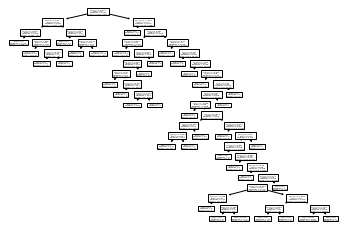

The center tree has a depth of 20 with 75 nodes.


In [24]:
tree.plot_tree(center_model)
plt.show()
center_tree_n_count = center_model.tree_.node_count
center_tree_depth = center_model.get_depth()
print(f'The center tree has a depth of {center_tree_depth} with {center_tree_n_count} nodes.')

### ALL NBA GUARD MACHINE LEARNING SECTION

In [25]:
X = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Guard==1]
X = X.drop(['AllNBA_Center','AllNBA_Forward','AllNBA_Guard','is_Guard','is_Center','is_Forward','WS/48','STL_pct','APG','GS'], axis=1)
X = X.drop(['Tm','Tm_1st','Tm_2nd','Tm_3rd'], axis=1)

y = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Guard==1]
y = y["AllNBA_Guard"].values.reshape(-1, 1)

# Splitting into Train and Test sets
# Creating StandardScaler instance
# Fitting Standard Scaller
# Scaling data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

#oversampling
X_train, y_train = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_Guard_Train = X_train
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier(max_depth=25, random_state=78)

guard_model = model.fit(X_train_scaled, y_train)


# Making predictions using the testing data
predictions = guard_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2028,27
Actual 1,17,35


Accuracy Score : 0.9791172282866635
Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2055
         1.0       0.56      0.67      0.61        52

    accuracy                           0.98      2107
   macro avg       0.78      0.83      0.80      2107
weighted avg       0.98      0.98      0.98      2107



In [26]:
# Sort the features by their importance.
importances =guard_model.feature_importances_
guard_feature_importance = sorted(zip(guard_model.feature_importances_, X.columns), reverse=True)
guard_feature_importance

[(0.8432685147662676, 'WS'),
 (0.045282126786751864, 'PPG'),
 (0.013355874414302926, 'PER'),
 (0.011785034266988664, 'DRB_pct'),
 (0.011241553905530497, '3PAr'),
 (0.010006663819445653, 'DRB'),
 (0.006078977712965507, 'FT'),
 (0.005351503209024523, 'Age'),
 (0.005035323492048779, 'AST_pct'),
 (0.004900313321930378, 'TOV'),
 (0.0038229514591904823, 'DWS'),
 (0.0033184055212823475, 'MP'),
 (0.0032302495118990853, 'FT_pct'),
 (0.003083524405247311, 'ORB_pct'),
 (0.002976653482588358, 'USG_pct'),
 (0.00288890271537461, 'FTr'),
 (0.0026852366677606867, 'G'),
 (0.0025792836534454886, 'FG'),
 (0.002494135270476092, 'VORP'),
 (0.002123647653629198, 'FG_pct'),
 (0.002049735836033535, '2P_pct'),
 (0.0018859999389401838, 'PF'),
 (0.0015544377394345603, 'PTS'),
 (0.0015298522919644482, 'OBPM'),
 (0.0015295139097998647, 'OWS'),
 (0.0012674716145031563, 'DBPM'),
 (0.001208794849473106, 'BPM'),
 (0.000958360067040723, '3P_pct'),
 (0.0009078895245675199, '2P'),
 (0.000636302312305623, 'SPG'),
 (0.0006

In [ ]:
tree.plot_tree(guard_model)
plt.show()
guard_tree_n_count = guard_model.tree_.node_count
guard_tree_depth = guard_model.get_depth()
print(f'The guard tree has a depth of {guard_tree_depth} with {guard_tree_n_count} nodes.')

### ALL NBA FORWARD MACHINE LEARNING SECTION

In [ ]:
X = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Forward==1]
X = X.drop(['AllNBA_Center','AllNBA_Forward','AllNBA_Guard','is_Guard','is_Center','is_Forward','WS/48','STL_pct','APG','GS'], axis=1)
X = X.drop(['Tm','Tm_1st','Tm_2nd','Tm_3rd'], axis=1)

y = Season_Stats_ML_DF[Season_Stats_ML_DF.is_Forward==1]
y = y["AllNBA_Forward"].values.reshape(-1, 1)

# Splitting into Train and Test sets
# Creating StandardScaler instance
# Fitting Standard Scaller
# Scaling data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

#oversampling
X_train, y_train = ros.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_Forward_Train = X_train
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier(max_depth=19, random_state=78)

forward_model = model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = forward_model.predict(X_test_scaled)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix Forwards")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
# We can sort the features by their importance.
importances = forward_model.feature_importances_
forward_feature_importance = sorted(zip(forward_model.feature_importances_, X.columns), reverse=True)
forward_feature_importance


In [ ]:
tree.plot_tree(forward_model)
plt.show()
forward_tree_n_count = forward_model.tree_.node_count
forward_tree_depth = forward_model.get_depth()
print(f'The foward tree has a depth of {forward_tree_depth} with {forward_tree_n_count} nodes.')

### PREDICTIONS

In [ ]:
testing_stats_sql = 'SELECT * FROM public.testing_stats'
seasons_stats_2021 = pd.read_sql(testing_stats_sql, con=connection)

#Points per Game
seasons_stats_2021["PPG"] = seasons_stats_2021["PTS"]/seasons_stats_2021["G"]
#Assits Per Game
seasons_stats_2021["APG"] = seasons_stats_2021["AST"]/seasons_stats_2021["G"]
#Rebounds Per Game
seasons_stats_2021["RPG"] = seasons_stats_2021["TRB"]/seasons_stats_2021["G"]
#Blocks Per Game
seasons_stats_2021["BPG"] = seasons_stats_2021["BLK"]/seasons_stats_2021["G"]
#STLs Per Game
seasons_stats_2021["SPG"] = seasons_stats_2021["STL"]/seasons_stats_2021["G"]    

In [ ]:
# Clean players that were on multiple teams
seasons_stats_2021[seasons_stats_2021.Player == 'Wendell Carter Jr.']

In [ ]:
# Clean players that were on multiple teams
traded_players = list(seasons_stats_2021[seasons_stats_2021.Tm == 'TOT'].Player)

def was_traded(Player,traded_players):
    was_traded_num = 0 
    if Player in traded_players: was_traded_num=1
    return was_traded_num

seasons_stats_2021['was_traded'] = seasons_stats_2021.Player.apply(lambda player: was_traded(player,traded_players) )
seasons_stats_2021 = seasons_stats_2021[(seasons_stats_2021.Tm == 'TOT') | (seasons_stats_2021.was_traded == 0)]
seasons_stats_2021=seasons_stats_2021.drop(['was_traded'], axis=1)
seasons_stats_2021[seasons_stats_2021.Player == 'Wendell Carter Jr.']


In [ ]:
# Scale stats for shortened season
def scale_stats(season_df, num_games):
    #scaled_season_df = pd.DataFrame()
    for stat in scaled_stats:
        season_df[stat] = season_df[stat] * 82/num_games
    return season_df

seasons_stats_2021 = scale_stats(seasons_stats_2021,72)

In [ ]:
centers_stats_2021 = seasons_stats_2021
forwards_stats_2021 = seasons_stats_2021
guards_stats_2021 = seasons_stats_2021

centers_stats_2021['is_Center'] = centers_stats_2021['Pos'].apply(lambda pos: is_center(pos) )
guards_stats_2021['is_Guard'] = guards_stats_2021['Pos'].apply(lambda pos: is_guard(pos) )
forwards_stats_2021['is_Forward'] = forwards_stats_2021['Pos'].apply(lambda pos: is_forward(pos) )

centers_stats_2021=centers_stats_2021[centers_stats_2021['is_Center']==1]
guards_stats_2021=guards_stats_2021[guards_stats_2021['is_Guard']==1]
forwards_stats_2021=forwards_stats_2021[forwards_stats_2021['is_Forward']==1]

centers_stats_2021=centers_stats_2021[centers_stats_2021['is_Center']==1].reset_index()
guards_stats_2021=guards_stats_2021[guards_stats_2021['is_Guard']==1].reset_index()
forwards_stats_2021=forwards_stats_2021[forwards_stats_2021['is_Forward']==1].reset_index()


In [ ]:
#Predict All- nba Centers
X_scaler = StandardScaler().fit(X_Center_Train)
X_test_scaled = X_scaler.transform(centers_stats_2021[['Age','G','MP','PER','TS_pct','3PAr','FTr','ORB_pct',
                                                       'DRB_pct','TRB_pct','AST_pct','BLK_pct',
                                                       'TOV_pct','USG_pct','OWS', 'DWS','WS','OBPM',
                                                       'DBPM','BPM','VORP','FG','FGA','FG_pct','3P',
                                                       '3PA','3P_pct','2P','2PA','2P_pct','eFG_pct',
                                                       'FT','FTA','FT_pct','ORB','DRB','TRB','AST',
                                                       'STL','BLK','TOV','PF','PTS','PPG','RPG','SPG']])
X_test_scaled = np.nan_to_num(X_test_scaled)
predictions = center_model.predict(X_test_scaled)
predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.rename(columns = {predictions_df.columns[0]:'All_NBA_Status'})
centers_stats_2021=centers_stats_2021.join(predictions_df)
# List All NBA team players in order of feature importance
allnbacenter_df = centers_stats_2021[centers_stats_2021.All_NBA_Status == 1].sort_values(by=['WS','DWS','PER','RPG','TOV','TRB'],ascending=False).head(3)
allnbacenter_df

In [ ]:
#Predict All- nba Guards
X_scaler = StandardScaler().fit(X_Guard_Train)
X_test_scaled = X_scaler.transform(guards_stats_2021[['Age','G','MP','PER','TS_pct','3PAr','FTr','ORB_pct',
                                                      'DRB_pct','TRB_pct','AST_pct','BLK_pct','TOV_pct','USG_pct',
                                                      'OWS', 'DWS','WS','OBPM','DBPM','BPM','VORP','FG','FGA',
                                                      'FG_pct','3P','3PA','3P_pct','2P','2PA','2P_pct','eFG_pct',
                                                      'FT','FTA','FT_pct','ORB','DRB','TRB','AST','STL','BLK',
                                                      'TOV','PF','PTS','PPG','RPG','SPG']])
X_test_scaled = np.nan_to_num(X_test_scaled)
predictions = guard_model.predict(X_test_scaled)
predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.rename(columns = {predictions_df.columns[0]:'All_NBA_Status'})
guards_stats_2021=guards_stats_2021.join(predictions_df)
# List All NBA team players in order of feature importance
allnbaguard_df=guards_stats_2021[guards_stats_2021.All_NBA_Status == 1].sort_values(by=['WS','PPG','PER','3PAr','DRB_pct','DRB','FT'],ascending=False).head(6)
allnbaguard_df

In [ ]:
#Predict All- nba Forwards
X_scaler = StandardScaler().fit(X_Forward_Train)
X_test_scaled = X_scaler.transform(forwards_stats_2021[['Age','G','MP','PER','TS_pct','3PAr','FTr','ORB_pct','DRB_pct',
                                                        'TRB_pct','AST_pct','BLK_pct','TOV_pct','USG_pct','OWS', 'DWS',
                                                        'WS','OBPM','DBPM','BPM','VORP','FG','FGA','FG_pct','3P','3PA',
                                                        '3P_pct','2P','2PA','2P_pct','eFG_pct','FT','FTA','FT_pct','ORB',
                                                        'DRB','TRB','AST','STL','BLK','TOV','PF','PTS','PPG','RPG','SPG']])
X_test_scaled = np.nan_to_num(X_test_scaled)
predictions = forward_model.predict(X_test_scaled)
predictions_df = pd.DataFrame(predictions)
predictions_df = predictions_df.rename(columns = {predictions_df.columns[0]:'All_NBA_Status'})
forwards_stats_2021=forwards_stats_2021.join(predictions_df)
# List All NBA team players in order of feature importance
allnbaforward_df=forwards_stats_2021[forwards_stats_2021.All_NBA_Status == 1].sort_values(by=['PPG','VORP','WS','PER','TRB_pct','FTr','DWS'],ascending=False).head(6)
allnbaforward_df

In [ ]:
# fix the all nba column to only include top 6 (or 3 for centers) choices
allnba_list=list(allnbacenter_df.Player)+ list(allnbaforward_df.Player)+ list(allnbaguard_df.Player)

def all_nba_final(player,playerlist):
    allnba = 0
    if player in playerlist: allnba=1
    return allnba
    
#all_nba_final('Bam Adebayo',allnbacenter_list)

forwards_stats_2021.All_NBA_Status = forwards_stats_2021.Player.apply(lambda player: all_nba_final(player,allnba_list) )
guards_stats_2021.All_NBA_Status = guards_stats_2021.Player.apply(lambda player: all_nba_final(player,allnba_list) )
centers_stats_2021.All_NBA_Status = centers_stats_2021.Player.apply(lambda player: all_nba_final(player,allnba_list) )
centers_stats_2021[centers_stats_2021.All_NBA_Status==1]


In [ ]:
forwards_stats_2021.to_csv('files_for_tableau_testing/forwards_stats_2021.csv',index=False)
guards_stats_2021.to_csv('files_for_tableau_testing/guards_stats_2021.csv',index=False)
centers_stats_2021.to_csv('files_for_tableau_testing/centers_stats_2021.csv',index=False)

In [ ]:
forward_feature_importance_df = pd.DataFrame(forward_feature_importance)
forward_feature_importance_df=forward_feature_importance_df.rename(columns = {forward_feature_importance_df.columns[0]:'Feature Importance'})
forward_feature_importance_df=forward_feature_importance_df.rename(columns = {forward_feature_importance_df.columns[1]:'Statistic'})
forward_feature_importance_df['Position'] = 'F'


In [ ]:
guard_feature_importance_df = pd.DataFrame(guard_feature_importance)
guard_feature_importance_df=guard_feature_importance_df.rename(columns = {guard_feature_importance_df.columns[0]:'Feature Importance'})
guard_feature_importance_df=guard_feature_importance_df.rename(columns = {guard_feature_importance_df.columns[1]:'Statistic'})
guard_feature_importance_df['Position'] = 'G'


In [ ]:
center_feature_importance_df = pd.DataFrame(center_feature_importance)
center_feature_importance_df=center_feature_importance_df.rename(columns = {center_feature_importance_df.columns[0]:'Feature Importance'})
center_feature_importance_df=center_feature_importance_df.rename(columns = {center_feature_importance_df.columns[1]:'Statistic'})
center_feature_importance_df['Position'] = 'C'

In [ ]:
feature_importance_df=forward_feature_importance_df.append(guard_feature_importance_df, ignore_index=True).append(center_feature_importance_df, ignore_index=True)
feature_importance_df.to_csv('files_for_tableau_testing/feature_importance_df.csv',index=False)